In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
import torch.nn.functional as F

from datasets import load_dataset
import torchvision
from denoising_diffusion_pytorch import Unet
from torch.optim import Adam
import tqdm
from torch.cuda.amp import GradScaler
scaler = GradScaler()
device = torch.device("cuda")

In [4]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start,beta_end,timesteps)

## Parameters of noise

In [9]:
timesteps = 500

betas = linear_beta_schedule(timesteps).to(device)
alphas = 1.-betas
alphas_cumprod = torch.cumprod(alphas,axis=0) #累乘 
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.-alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)

alphas_cumprod_prev = F.pad(alphas_cumprod[:-1],(1,0),value=1.0) # t时刻对应的alpht_{t-1}的累乘
posterior_variance = betas*(1.-alphas_cumprod_prev) / (1-alphas_cumprod) # Xt时刻的分布方差

## Dataset

In [10]:
dataset = load_dataset("fashion_mnist")
image_size = 28
channels =1
batch_size = 128

from torch.utils.data import DataLoader

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t:(t*2)-1)
])

def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
dataloader = DataLoader(transformed_dataset["train"],batch_size=batch_size,shuffle=True,num_workers=2)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Training stage: using $X_t$ to predict the noise $ Z_t$

In [11]:
def extract(a,t,x_shape):
    bs = x_shape[0]
    out = a.gather(-1,t)
    return out.reshape(bs,*((1,)*(len(x_shape)-1))).to(device)# (bs)->(bs,1,1,1)
    

In [12]:
epochs = 5
model = Unet(dim=18,channels=1,dim_mults=(1,2,4),resnet_block_groups=6).to(device)
optimizer = Adam(model.parameters(), lr = 8e-5, betas = (0.9, 0.99))
lf = lambda x: (1 - x / (epochs - 1)) * (1.0 - 0.01) + 0.01  # linear
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
model.train()
for epoch in range(epochs):
    total_loss = 0.
    progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))
    for step,batch in progress_bar:
        batch = batch["pixel_values"].to(device)
        bs = batch.size()[0]
        t = torch.randint(0,timesteps,(bs,),device=device).long()
        
        # generate noise
        noise = torch.randn_like(batch).to(device)
        
        # Adding Noise_T to X_0
        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod,t,batch.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod,t,batch.shape)
        
        x_t = sqrt_alphas_cumprod_t*batch + sqrt_one_minus_alphas_cumprod_t*noise
        predicted_noise = model(x_t,t)
        
        loss = F.smooth_l1_loss(noise,predicted_noise)
        
        total_loss += loss.data
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)
        s = ('epoch: %10s' + 'loss: %10.4g' + 'Mem: %10s') % ('%g/%g' % (epoch + 1, epochs), total_loss / (step + 1), mem)
        progress_bar.set_description(s)

epoch:        5/5loss:    0.03791Mem:      1.74G: 100%|██████████| 469/469 [01:06<00:00,  7.03it/s]


## 模型保存

In [13]:
import os
save = {'state_dict': model.state_dict()}
torch.save(save, os.path.join("/kaggle/working/", 'weights.pth'))

## Sampling

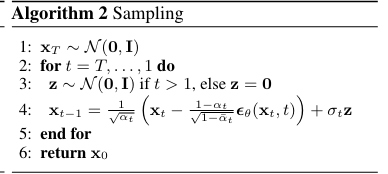

In [ ]:
model = Unet(dim=18,channels=1,dim_mults=(1,2,4),resnet_block_groups=6).to(device)
model.load_state_dict(torch.load(args.model_path)['state_dict'])

In [14]:
img = torch.randn((1,1,28,28),device=device)  # X_t 随机高斯分布的噪声
model.eval()
imgs = []
for current_t in tqdm.tqdm(reversed(range(0,timesteps))):
    bs = img.size()[0]
    t = torch.full((bs,),current_t,device=device,dtype=torch.long)
    
    #calculate the means and std of the distribution of X_{t-1}
    betas_t = extract(betas,t,img.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod,t,img.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas,t,img.shape)
    
    # get the prediction noise z_t
    with torch.no_grad():
        z_t = model(img,t)
    mean = sqrt_recip_alphas_t*(img-betas_t/sqrt_one_minus_alphas_cumprod_t*z_t)
    
    # 根据均值方差重参数化采样：
    if current_t>0:
        posterior_variance_t = extract(posterior_variance,t,img.shape)
        img = mean+torch.sqrt(posterior_variance_t)*torch.randn_like(img)
    else:
        img = mean
    imgs.append(img.cpu().numpy())

500it [00:12, 40.01it/s]


In [15]:
def unnormalize(img):
    return (img + 1) * 0.5

## Visualization

In [16]:
from matplotlib import pyplot as plt 

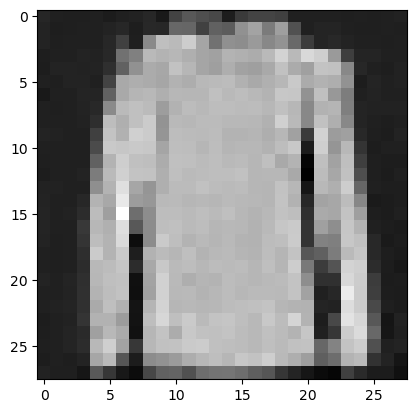

In [18]:
plt.imshow(unnormalize(imgs[-1][0]).reshape(28,28,1),cmap="gray")

### Save as gif

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ims= []
for i in tqdm.tqdm(range(timesteps)):
    im = plt.imshow(unnormalize(imgs[i][0]).reshape(28,28,1),cmap="gray",animated=True)
    ims.append([im])
ims = ims[::10]
animate = animation.ArtistAnimation(fig,ims,interval=50,blit=True,repeat_delay=1000)
animate.save("/kaggle/working/diffusion_2.gif")

100%|██████████| 500/500 [00:00<00:00, 1295.95it/s]


In [24]:
!cd /kaggle/working

![Animation](./diffusion_2.gif)